# Домашняя работа №6

## Задание №1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_matcher: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import warnings
warnings.filterwarnings('ignore')

# Написанные нами функции
from metrics import precision_at_k, recall_at_k
from utils import prefilter_items
from recommenders import MainRecommender

In [2]:
data = pd.read_csv('../data/retail_train.csv')
item_features = pd.read_csv('../data/product.csv')
user_features = pd.read_csv('../data/hh_demographic.csv')

In [3]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

In [4]:
# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)


VAL_MATCHER_WEEKS = 6
VAL_RANKER_WEEKS = 3

# Split dataset for train, eval, test

In [5]:
# берем данные для тренировки matching модели
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

# берем данные для валидации matching модели
data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]


# берем данные для тренировки ranking модели
data_train_ranker = data_val_matcher.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться

# берем данные для теста ranking, matching модели
data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

In [6]:
def print_stats_data(df_data, name_df):
    print(name_df)
    print(f"Shape: {df_data.shape} Users: {df_data[USER_COL].nunique()} Items: {df_data[ITEM_COL].nunique()}")
    
print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (2108779, 12) Users: 2498 Items: 83685
val_matcher
Shape: (169711, 12) Users: 2154 Items: 27649
train_ranker
Shape: (169711, 12) Users: 2154 Items: 27649
val_ranker
Shape: (118314, 12) Users: 2042 Items: 24329


# Prefilter items

In [7]:
n_items_before = data_train_matcher['item_id'].nunique()

data_train_matcher = prefilter_items(data_train_matcher, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_matcher['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 5001


# Make cold-start to warm-start

In [8]:
# ищем общих пользователей
common_users = data_train_matcher.user_id.values

data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (861404, 13) Users: 2495 Items: 5001
val_matcher
Shape: (169615, 12) Users: 2151 Items: 27644
train_ranker
Shape: (169615, 12) Users: 2151 Items: 27644
val_ranker
Shape: (118282, 12) Users: 2040 Items: 24325


# Init/train recommender

In [9]:
recommender = MainRecommender(data_train_matcher)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5001 [00:00<?, ?it/s]

In [10]:
ACTUAL_COL = 'actual'

In [11]:
result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
result_eval_matcher.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [15]:
N_PREDICT = 50

def calc_get_own(df_data, recommend_model, columns_name, top_k):
    df_data[columns_name] = df_data[USER_COL].apply(lambda x: recommend_model(x, N=top_k))
    return df_data

def evalRecall(df_data, recommend_model, top_k, n_predict):
    for name, model in recommend_model.items():
        df_data = calc_get_own(df_data, model, name, n_predict)
    recall = sorted(calc_recall(df_data, top_k), key=lambda x: x[1],reverse=True)
    return pd.DataFrame(recall, columns=['Name', 'Score'])

def evalPrecision(df_data, recommend_model, top_k, n_predict):
    for name, model in recommend_model.items():
        df_data = calc_get_own(df_data, model, name, n_predict)
    precision = sorted(calc_precision(df_data, top_k), key=lambda x: x[1],reverse=True)
    return pd.DataFrame(precision, columns=['Name', 'Score'])

def calc_recall(df_data, top_k):
    for col_name in df_data.columns[1:]:
        yield col_name, round(df_data.apply(lambda row: recall_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean(), 3)

def calc_precision(df_data, top_k):
    for col_name in df_data.columns[1:]:
        yield col_name, round(df_data.apply(lambda row: precision_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean(), 3)

In [16]:
eval_matcher = {'own_rec': recommender.get_own_recommendations, 
                'sim_item_rec': recommender.get_similar_items_recommendation, 
                'als_rec': recommender.get_als_recommendations}

In [17]:
TOP_PRECISION = 5 
evalPrecision(result_eval_matcher, eval_matcher, TOP_PRECISION, N_PREDICT)

,Name,Score
0,actual,1.000
1,own_rec,0.177
2,als_rec,0.121
3,sim_item_rec,0.053


In [19]:
ACTUAL_COL = 'actual'

result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
result_eval_matcher.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [20]:
k = [10, 20, 30, 40, 50, 100, 200, 500] 

recall = []
eval_matcher = {'own_rec': recommender.get_own_recommendations}

for predict in k:
    recall.append(evalRecall(result_eval_matcher, eval_matcher, predict, predict)['Score'][1])

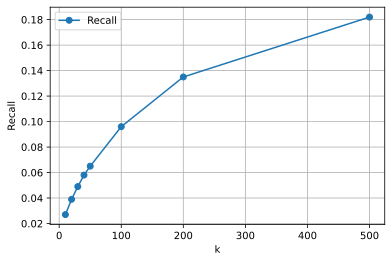

In [22]:
%config InlineBackend.figure_formats = ['svg']

plt.figure()
plt.plot(k, recall, 'o-', label='Recall')
plt.xlabel('k')
plt.ylabel('Recall')
plt.grid()
plt.legend()
plt.show()

Исходя из определения метрики Recall@k, чем k чем больше купленных товаров попадёт в релевантную рекомендацию, что мы и видим на графике. Исходя из правила локтя мы должны выбрать значение k в «изгибе», то есть в точке, после которой искажение/инерция начинают линейно уменьшаться. Таким образом, для заданных данных мы заключаем, что оптимальное количество кластеров для данных - 200

## Задание №2

Обучите модель 2-ого уровня, при этом:

- Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар

- Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_ranker

- Вырос ли precision@5 при использовании двухуровневой модели?

In [23]:
# взяли пользователей из трейна для ранжирования
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]

In [24]:
# собираем кандитатов с первого этапа (matcher)
N_PREDICT = 200

df_match_candidates = calc_get_own(df_match_candidates, recommender.get_own_recommendations, 'candidates', N_PREDICT)

In [25]:
df_match_candidates.head(2)

,user_id,candidates
0,2070,"[1105426, 1097350, 879194, 948640, 928263, 944..."
1,2021,"[950935, 1119454, 835578, 863762, 1019142, 102..."


In [26]:
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'
df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)
df_match_candidates.head(4)

,user_id,item_id
0,2070,1105426
0,2070,1097350
0,2070,879194
0,2070,948640


In [28]:
print_stats_data(df_match_candidates, 'match_candidates')

match_candidates
Shape: (430200, 2) Users: 2151 Items: 4598


In [29]:
# Создаем трейн сет для ранжирования с учетом кандидатов с этапа 1 
df_ranker_train = data_train_ranker[[USER_COL, ITEM_COL]].copy()
df_ranker_train['target'] = 1  # тут только покупки 
df_ranker_train.head(3)

,user_id,item_id,target
2104867,2070,1019940,1
2107468,2021,840361,1
2107469,2021,856060,1


Не хватает нулей в датасете, поэтому добавляем наших кандитатов в качество нулей

In [30]:
df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')

# чистим дубликаты
df_ranker_train = df_ranker_train.drop_duplicates(subset=[USER_COL, ITEM_COL])

df_ranker_train['target'].fillna(0, inplace= True)

df_ranker_train.head(2)

,user_id,item_id,target
0,2070,1105426,0.0
1,2070,1097350,0.0


In [31]:
df_ranker_train.target.value_counts()

0.0    397661
1.0     17984
Name: target, dtype: int64

#### Подготавливаем фичи для обучения модели

In [32]:
df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')

df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,1097350,0.0,2468,GROCERY,National,DOMESTIC WINE,VALUE GLASS WINE,4 LTR,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


#### Добавим минимум по 2 фичи для юзера, товара и пары юзер-товар

In [33]:
#Средний чек
data_train_ranker['price'] = data_train_ranker['sales_value'] / data_train_ranker['quantity']
df_ranker_train = df_ranker_train.merge(data_train_ranker.groupby(['user_id'])['price'].agg('mean'), on='user_id', how='left')
df_ranker_train.rename(columns={'price': 'average_check'}, inplace=True)

In [34]:
#Среднее количество пакупок
df = data_train_ranker.groupby(['user_id'])['quantity'].agg('mean').reset_index()
df.columns = ['user_id', 'naverage_purchases']
df_ranker_train = df_ranker_train.merge(df, on='user_id', how='left')

In [35]:
#цена
df_ranker_train = df_ranker_train.merge(data_train_ranker.groupby(['item_id'])['price'].agg('mean'), on='item_id', how='left')
df_ranker_train.price.fillna(0, inplace=True)

In [36]:
#сумма покупок в группе
df_com_price = df_ranker_train.groupby(['commodity_desc'])['price'].agg('mean').reset_index()
df_com_item = df_ranker_train.groupby(['commodity_desc'])['item_id'].nunique().reset_index()
df_com_item['purchases_group'] = df_com_item['item_id'] * df_com_price['price']
df_ranker_train= df_ranker_train.merge(df_com_item[['commodity_desc', 'purchases_group']], on='commodity_desc', how='left')

In [37]:
#Количество купленного товара в категории
df = df_ranker_train.groupby(['user_id', 'commodity_desc'])['item_id'].nunique().reset_index()
df.rename(columns={'item_id': 'commodity_item'}, inplace=True)
df_ranker_train = df_ranker_train.merge(df, on=['user_id', 'commodity_desc'], how='left')

In [38]:
#Количество купленного товара по брэндам
df = df_ranker_train.groupby(['user_id', 'brand'])['item_id'].nunique().reset_index()
df.rename(columns={'item_id': 'brand_item'}, inplace=True)
df_ranker_train = df_ranker_train.merge(df, on=['user_id', 'brand'], how='left')

Обучение модели ранжирования

In [39]:
col=['age_desc', 'marital_status_code', 'income_desc', 'homeowner_desc', 'hh_comp_desc', 'household_size_desc', 'kid_category_desc']
df_ranker_train.drop(columns=col, inplace=True)

In [40]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train[['target']]

In [41]:
cat_feats = X_train.columns[3:8].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')
X_train = X_train.join(pd.get_dummies(X_train[cat_feats]))
X_train.drop(columns=cat_feats, inplace=True)

In [55]:
%%time
from catboost import CatBoostClassifier

model = CatBoostClassifier(silent=True,
                           random_state=42,
                           custom_loss=['F1'],
                           early_stopping_rounds=500, 
                           iterations=500,
                           max_depth=12, 
                           min_data_in_leaf=3,
                           task_type="GPU",
                           gpu_ram_part=.99,
                          )

model.fit(X_train, y_train)
train_preds = model.predict_proba(X_train)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Wall time: 32.7 s


In [56]:
def rerank(user_id):
    return df_ranker_predict[df_ranker_predict[USER_COL]==user_id].sort_values('proba_item_purchase', ascending=False).head(TOPK_PRECISION).item_id.tolist()

In [57]:
df_ranker_predict = df_ranker_train.copy()
df_ranker_predict['proba_item_purchase'] = train_preds[:, 1]
ACTUAL_COL = 'actual'

result_eval_ranker = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_ranker.columns=[USER_COL, ACTUAL_COL]

TOPK_PRECISION = 5

result_eval_ranker['reranked_own_rec'] = result_eval_ranker[USER_COL].apply(lambda user_id: rerank(user_id))

In [58]:
sorted(calc_precision(result_eval_ranker, TOPK_PRECISION), key=lambda x: x[1], reverse=True)

[('actual', 1.0), ('reranked_own_rec', 0.175)]

In [ ]:
"""при более тщательном подборе параметров модели, и подбора фич 
   показатели  precision@5 будет увеличиваться"""